CODE BLOCK: 1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

CODE BLOCK: 2

In [3]:
# check if CUDA is available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? False


CODE BLOCK: 3

In [4]:

# Train data transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    ])

# load data sets for training and testing
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms) # flag


100%|████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [04:24<00:00, 644110.23it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


CODE BLOCK: 4

In [5]:
# batch size is the number of samples processed before the model is updated
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 5

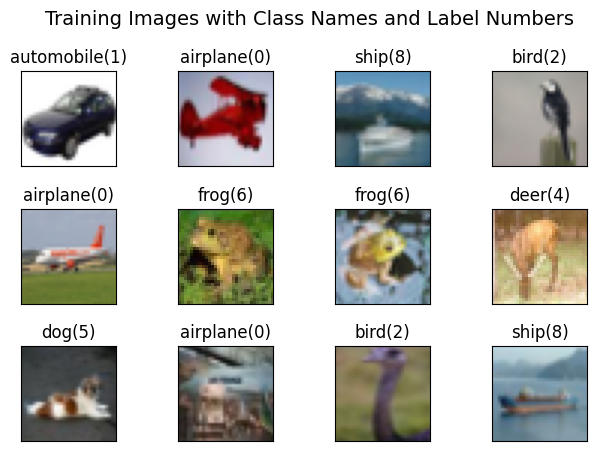

In [6]:
import matplotlib.pyplot as plt
import numpy as np
batch_data, batch_label = next(iter(train_loader))

# actual class names for CIFAR10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure()
plt.suptitle("Training Images with Class Names and Label Numbers", fontsize=14)

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  image = np.transpose(batch_data[i].numpy(), (1, 2, 0))
  plt.imshow(image)
  plt.title(f"{class_names[batch_label[i].item()]}({batch_label[i].item()})")
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 6

In [7]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}


def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 7

In [10]:
# model.py

import torch.nn as nn
import torch.nn.functional as F
from model import Net_BatchNorm as Net

# size1 = 16
# size2 = 24
# size3 = 32
# drop_value = 0.15
nclasses = 10

from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#
criterion = nn.CrossEntropyLoss()
num_epochs = 20


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,320
              ReLU-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]           2,320
             ReLU-10           [-1, 16, 32, 32]               0
      BatchNorm2d-11           [-1, 16, 32, 32]              32
          Dropout-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 10, 32, 32]             160
        MaxPool2d-14           [-1, 10,

**CODE** BLOCK: 8

In [8]:

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=1.5748 Batch_id=390 Accuracy=34.23: 100%|██████████| 391/391 [00:20<00:00, 18.67it/s]


Test set: Average loss: 0.0126, Accuracy: 4307/10000 (43.07%)

Epoch 2


Train: Loss=1.2530 Batch_id=390 Accuracy=46.78: 100%|██████████| 391/391 [00:12<00:00, 30.35it/s]


Test set: Average loss: 0.0119, Accuracy: 4597/10000 (45.97%)

Epoch 3


Train: Loss=1.1661 Batch_id=390 Accuracy=53.90: 100%|██████████| 391/391 [00:13<00:00, 30.01it/s]


Test set: Average loss: 0.0103, Accuracy: 5317/10000 (53.17%)

Epoch 4


Train: Loss=1.0855 Batch_id=390 Accuracy=58.13: 100%|██████████| 391/391 [00:12<00:00, 30.44it/s]


Test set: Average loss: 0.0100, Accuracy: 5523/10000 (55.23%)

Epoch 5


Train: Loss=1.0793 Batch_id=390 Accuracy=60.82: 100%|██████████| 391/391 [00:12<00:00, 30.11it/s]


Test set: Average loss: 0.0084, Accuracy: 6218/10000 (62.18%)

Epoch 6


Train: Loss=1.0019 Batch_id=390 Accuracy=62.98: 100%|██████████| 391/391 [00:12<00:00, 30.16it/s]


Test set: Average loss: 0.0094, Accuracy: 5925/10000 (59.25%)

Epoch 7


Train: Loss=1.0457 Batch_id=390 Accuracy=64.73: 100%|██████████| 391/391 [00:13<00:00, 29.87it/s]


Test set: Average loss: 0.0085, Accuracy: 6207/10000 (62.07%)

Epoch 8


Train: Loss=0.7896 Batch_id=390 Accuracy=66.02: 100%|██████████| 391/391 [00:14<00:00, 27.65it/s]


Test set: Average loss: 0.0075, Accuracy: 6667/10000 (66.67%)

Epoch 9


Train: Loss=1.0755 Batch_id=390 Accuracy=67.27: 100%|██████████| 391/391 [00:13<00:00, 29.99it/s]


Test set: Average loss: 0.0074, Accuracy: 6737/10000 (67.37%)

Epoch 10


Train: Loss=0.8115 Batch_id=390 Accuracy=68.45: 100%|██████████| 391/391 [00:12<00:00, 30.44it/s]


Test set: Average loss: 0.0071, Accuracy: 6787/10000 (67.87%)

Epoch 11


Train: Loss=0.9331 Batch_id=390 Accuracy=70.78: 100%|██████████| 391/391 [00:13<00:00, 30.01it/s]


Test set: Average loss: 0.0069, Accuracy: 6967/10000 (69.67%)

Epoch 12


Train: Loss=0.7791 Batch_id=390 Accuracy=71.22: 100%|██████████| 391/391 [00:12<00:00, 30.12it/s]


Test set: Average loss: 0.0068, Accuracy: 6993/10000 (69.93%)

Epoch 13


Train: Loss=0.5831 Batch_id=390 Accuracy=71.55: 100%|██████████| 391/391 [00:13<00:00, 29.94it/s]


Test set: Average loss: 0.0068, Accuracy: 6976/10000 (69.76%)

Epoch 14


Train: Loss=0.8608 Batch_id=390 Accuracy=71.73: 100%|██████████| 391/391 [00:13<00:00, 30.05it/s]


Test set: Average loss: 0.0066, Accuracy: 7071/10000 (70.71%)

Epoch 15


Train: Loss=1.1356 Batch_id=390 Accuracy=71.89: 100%|██████████| 391/391 [00:12<00:00, 30.14it/s]


Test set: Average loss: 0.0068, Accuracy: 6997/10000 (69.97%)

Epoch 16


Train: Loss=0.8095 Batch_id=390 Accuracy=72.23: 100%|██████████| 391/391 [00:13<00:00, 29.96it/s]


Test set: Average loss: 0.0068, Accuracy: 6984/10000 (69.84%)

Epoch 17


Train: Loss=1.0073 Batch_id=390 Accuracy=72.34: 100%|██████████| 391/391 [00:13<00:00, 29.86it/s]


Test set: Average loss: 0.0066, Accuracy: 7115/10000 (71.15%)

Epoch 18


Train: Loss=0.5525 Batch_id=390 Accuracy=72.57: 100%|██████████| 391/391 [00:12<00:00, 30.27it/s]


Test set: Average loss: 0.0067, Accuracy: 7035/10000 (70.35%)

Epoch 19


Train: Loss=0.7761 Batch_id=390 Accuracy=72.70: 100%|██████████| 391/391 [00:12<00:00, 30.20it/s]


Test set: Average loss: 0.0066, Accuracy: 7138/10000 (71.38%)

Epoch 20


Train: Loss=0.8673 Batch_id=390 Accuracy=72.57: 100%|██████████| 391/391 [00:12<00:00, 30.17it/s]


Test set: Average loss: 0.0066, Accuracy: 7131/10000 (71.31%)



**CODE** BLOCK: 9

Text(0.5, 1.0, 'Test Accuracy')

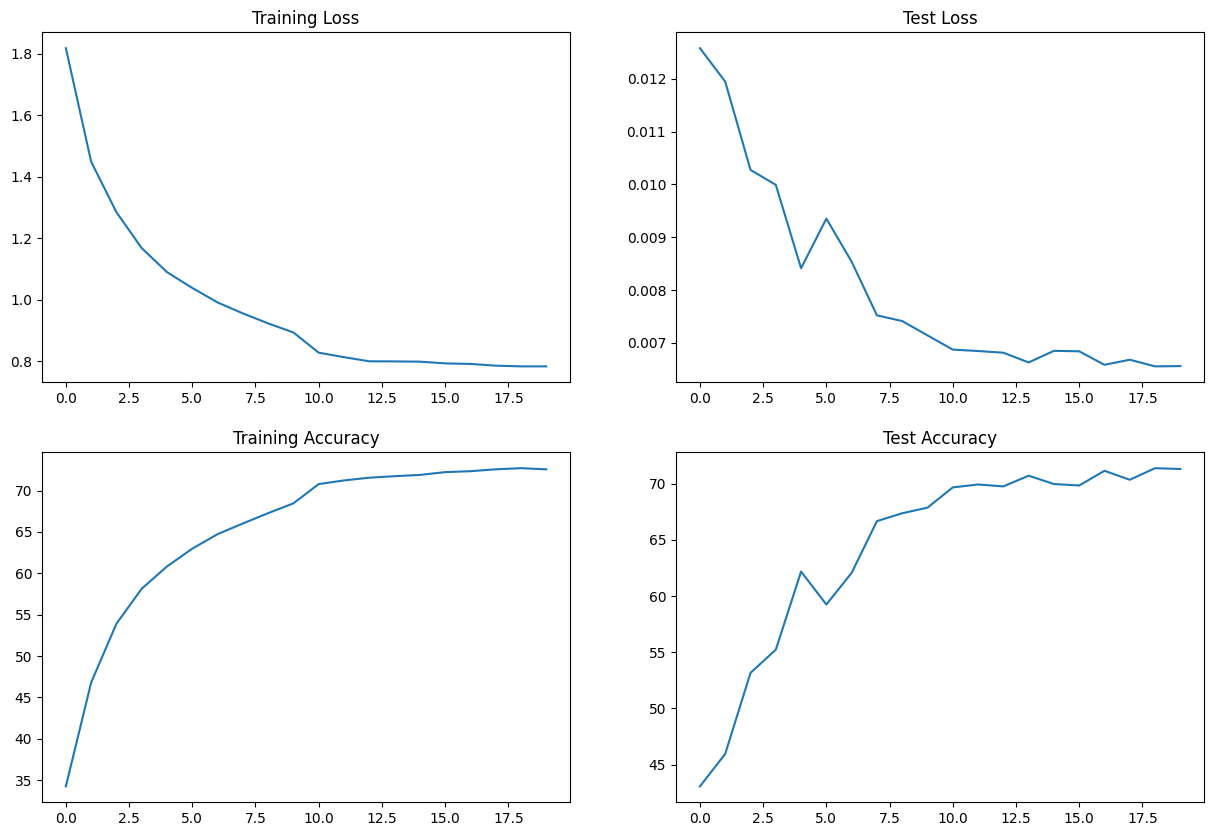

In [9]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

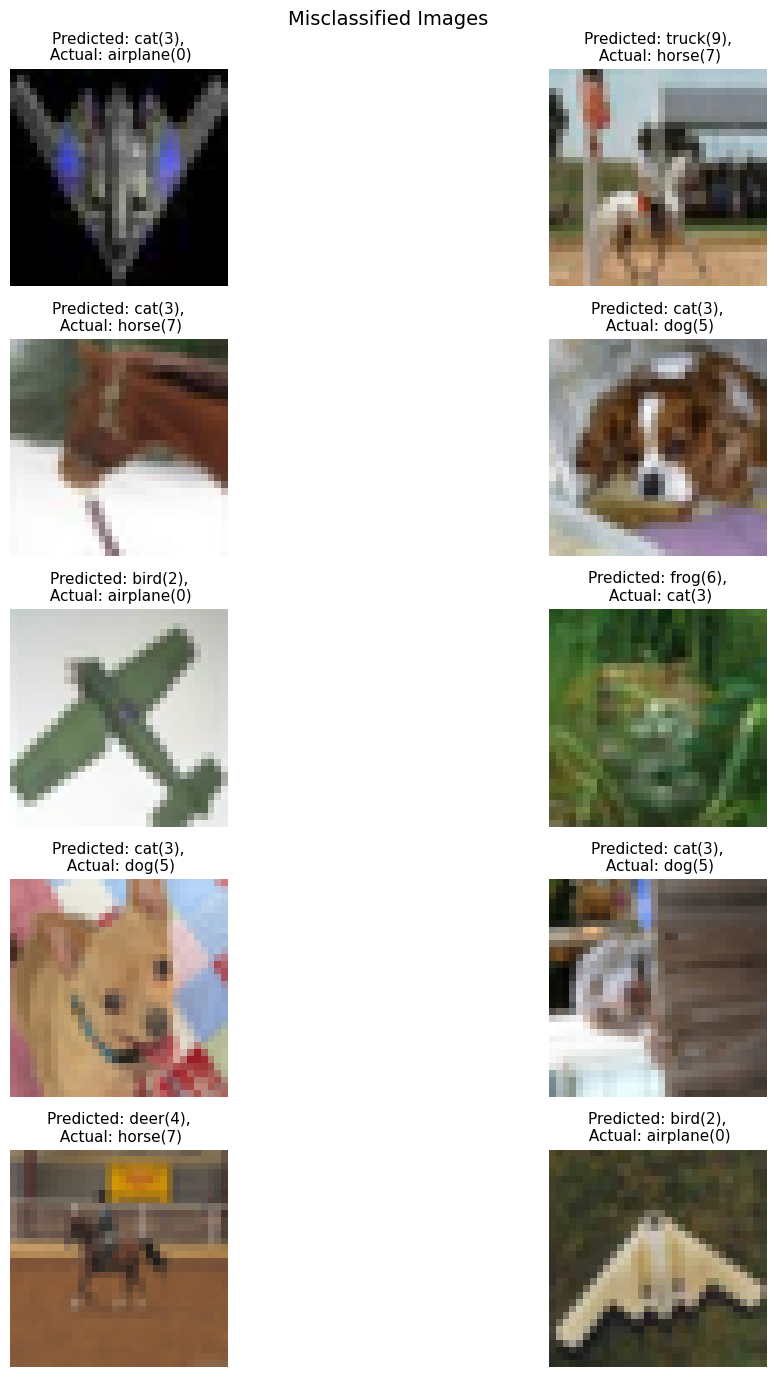

In [10]:
from torchvision import utils

# Set the model to evaluation mode
model.eval()


# List to store misclassified images and actual labels
misclassified_images = []
misclassified_labels = []
actual_labels = []

# Loop through the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        incorrect_mask = predicted != labels
        misclassified_images.append(images[incorrect_mask])
        misclassified_labels.append(predicted[incorrect_mask])
        actual_labels.append(labels[incorrect_mask])

# Concatenate the list of misclassified images
misclassified_images = torch.cat(misclassified_images)
misclassified_labels = torch.cat(misclassified_labels)
actual_labels        = torch.cat(actual_labels)
# Plot the misclassified images
plt.figure(figsize=(14, 14))
plt.suptitle("Misclassified Images", fontsize=14)

for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.imshow(np.transpose(misclassified_images[i].cpu().numpy(), (1, 2, 0)))
    mis_lab = misclassified_labels[i].item()
    act_lab = actual_labels[i].item()
    plt.title(f"Predicted: {class_names[mis_lab]}({mis_lab}),\n Actual: {class_names[act_lab]}({act_lab})", fontsize=11)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save the misclassified images as a single image
from torchvision.utils import save_image

# Convert the misclassified images tensor to a grid
grid_image = utils.make_grid(misclassified_images, nrow=5)

# Save the grid image
utils.save_image(grid_image, 'misclassified_images.png')


In [11]:

min_train_loss_epoch = train_losses.index(min(train_losses)) + 1
min_test_loss_epoch = test_losses.index(min(test_losses)) + 1
best_train_acc_epoch = train_acc.index(max(train_acc)) + 1
best_test_acc_epoch = test_acc.index(max(test_acc)) + 1

print("Minimum training loss = {:.9f}% at epoch {}".format(min(train_losses), min_train_loss_epoch))
print("Minimum testing loss = {:.9f}% at epoch {}".format(min(test_losses), min_test_loss_epoch))
print("Best training accuracy = {:.2f}% at epoch {}".format(max(train_acc), best_train_acc_epoch))
print("Best testing accuracy = {:.2f}% at epoch {}".format(max(test_acc), best_test_acc_epoch))


Minimum training loss = 0.783696937% at epoch 19
Minimum testing loss = 0.006552949% at epoch 19
Best training accuracy = 72.70% at epoch 19
Best testing accuracy = 71.38% at epoch 19


##**Target**

- Batch Normalization aims to stabilize the learning process and improve convergence times by normalizing the inputs of each layer
- It can reduce internal covariate shift


##**Results:**

- Total parameters: 40,248
- Best train accuracy: 72.70% at epoch 20
- Best test accuracy: 71.38% at epoch 19

# **Analysis**

- Accuracy of more than 70% can be achieved with fewer than 50000 parameters
- Training accuracy is slightly better than test accuracy and it indicates overfitting. Increasing dropout value did not remove this aspect.